In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45204,NaN,NaN,International,2020-09-19,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45205,NaN,NaN,International,2020-09-20,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45206,NaN,NaN,International,2020-09-21,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


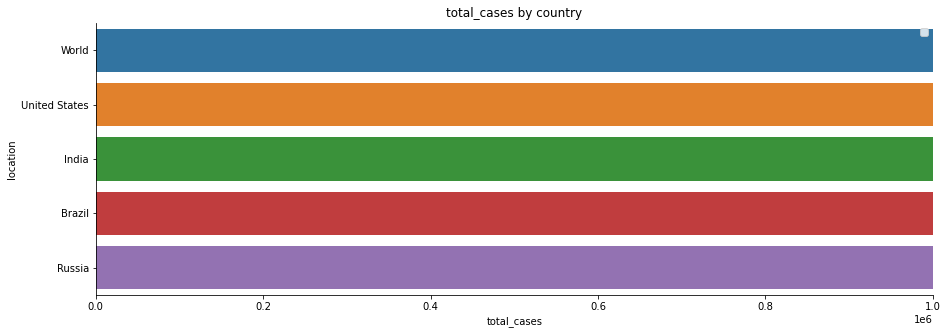

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


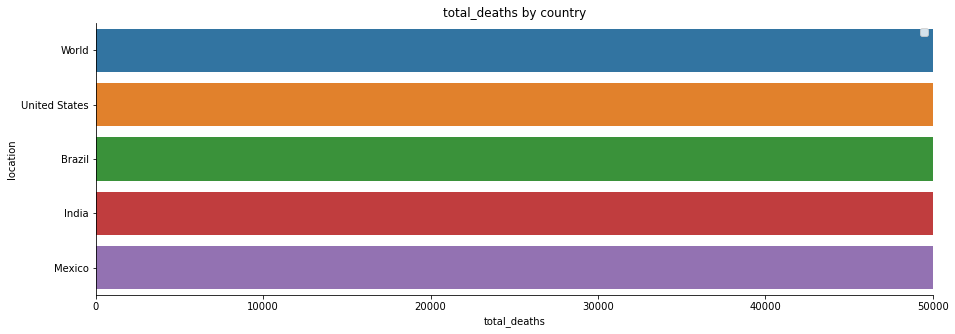

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


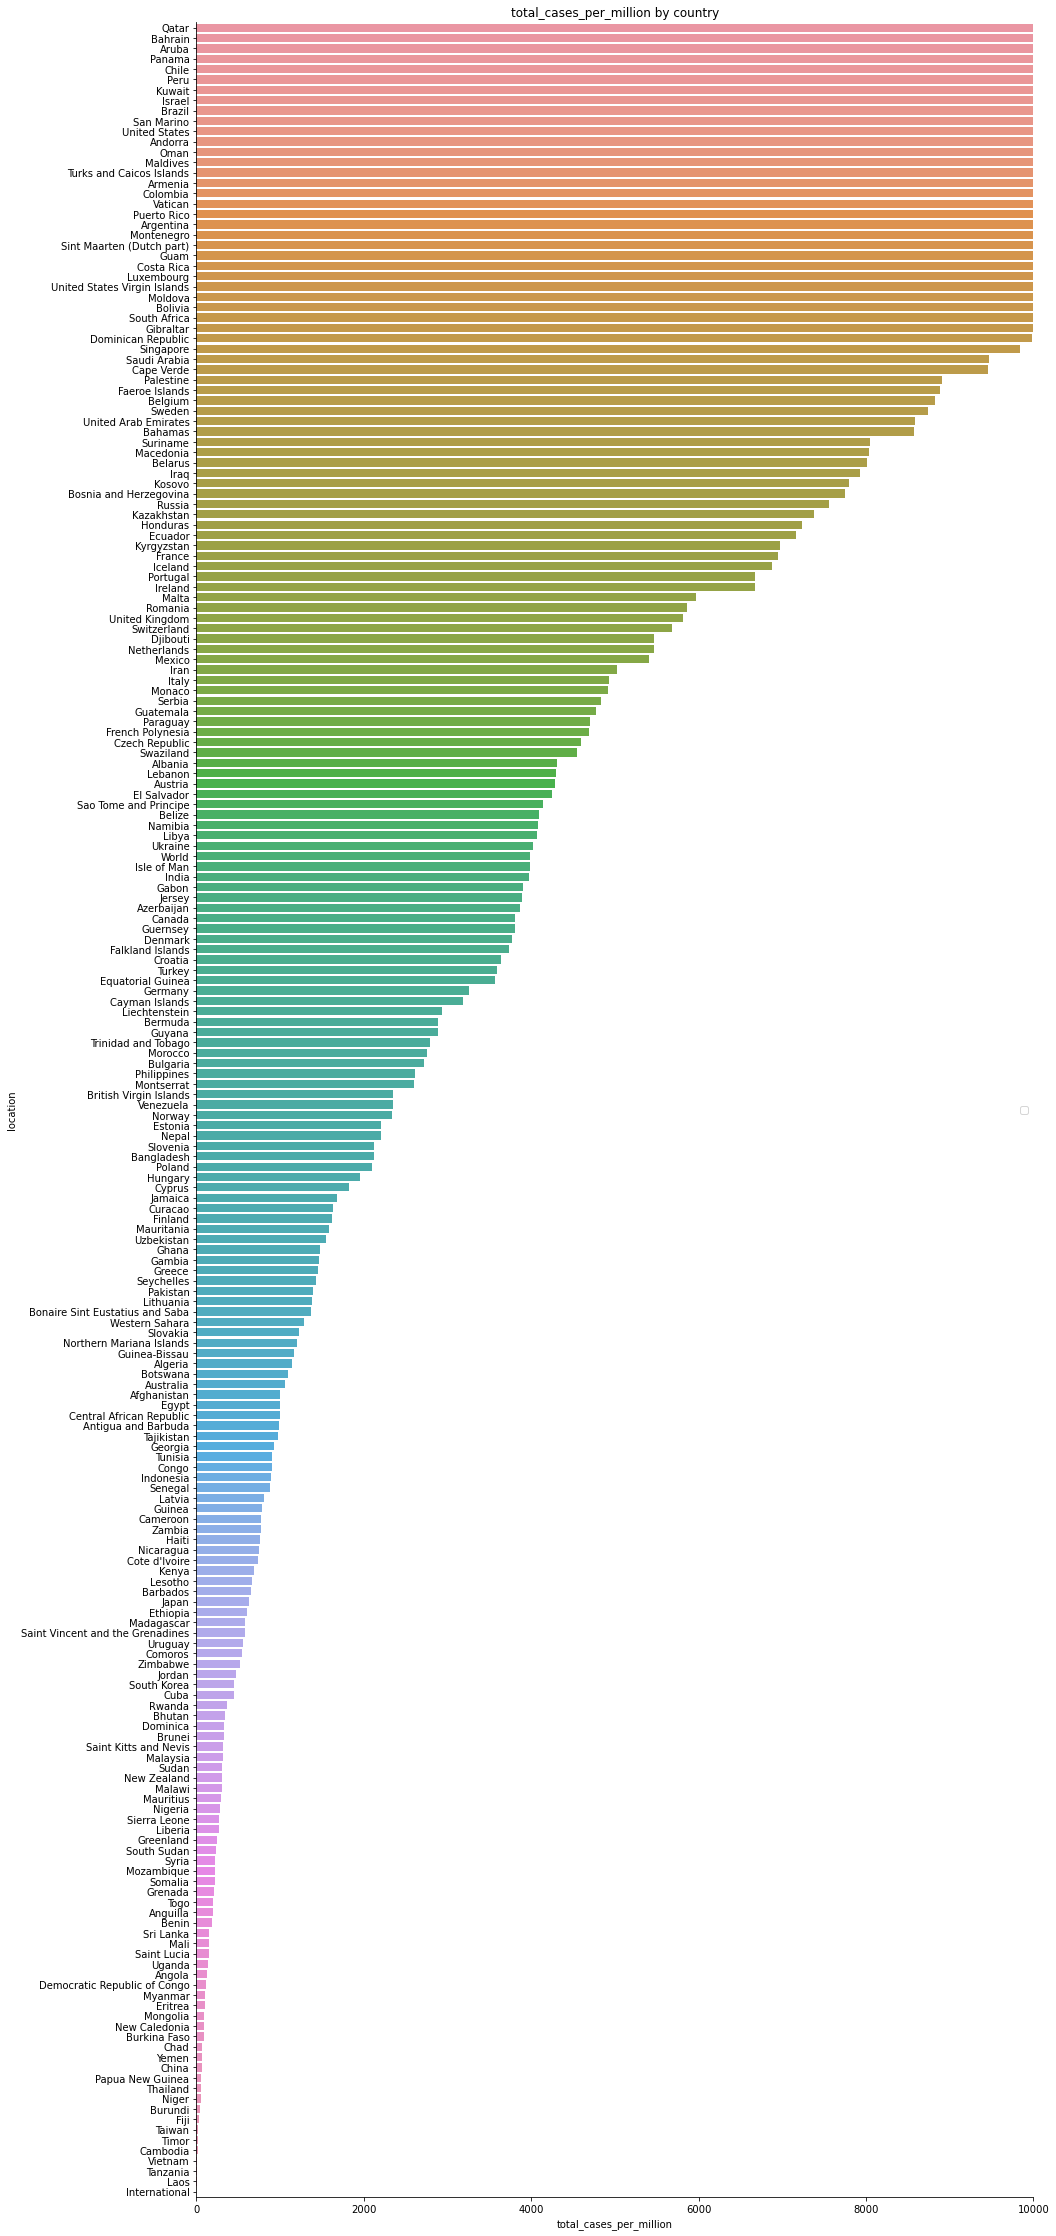

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


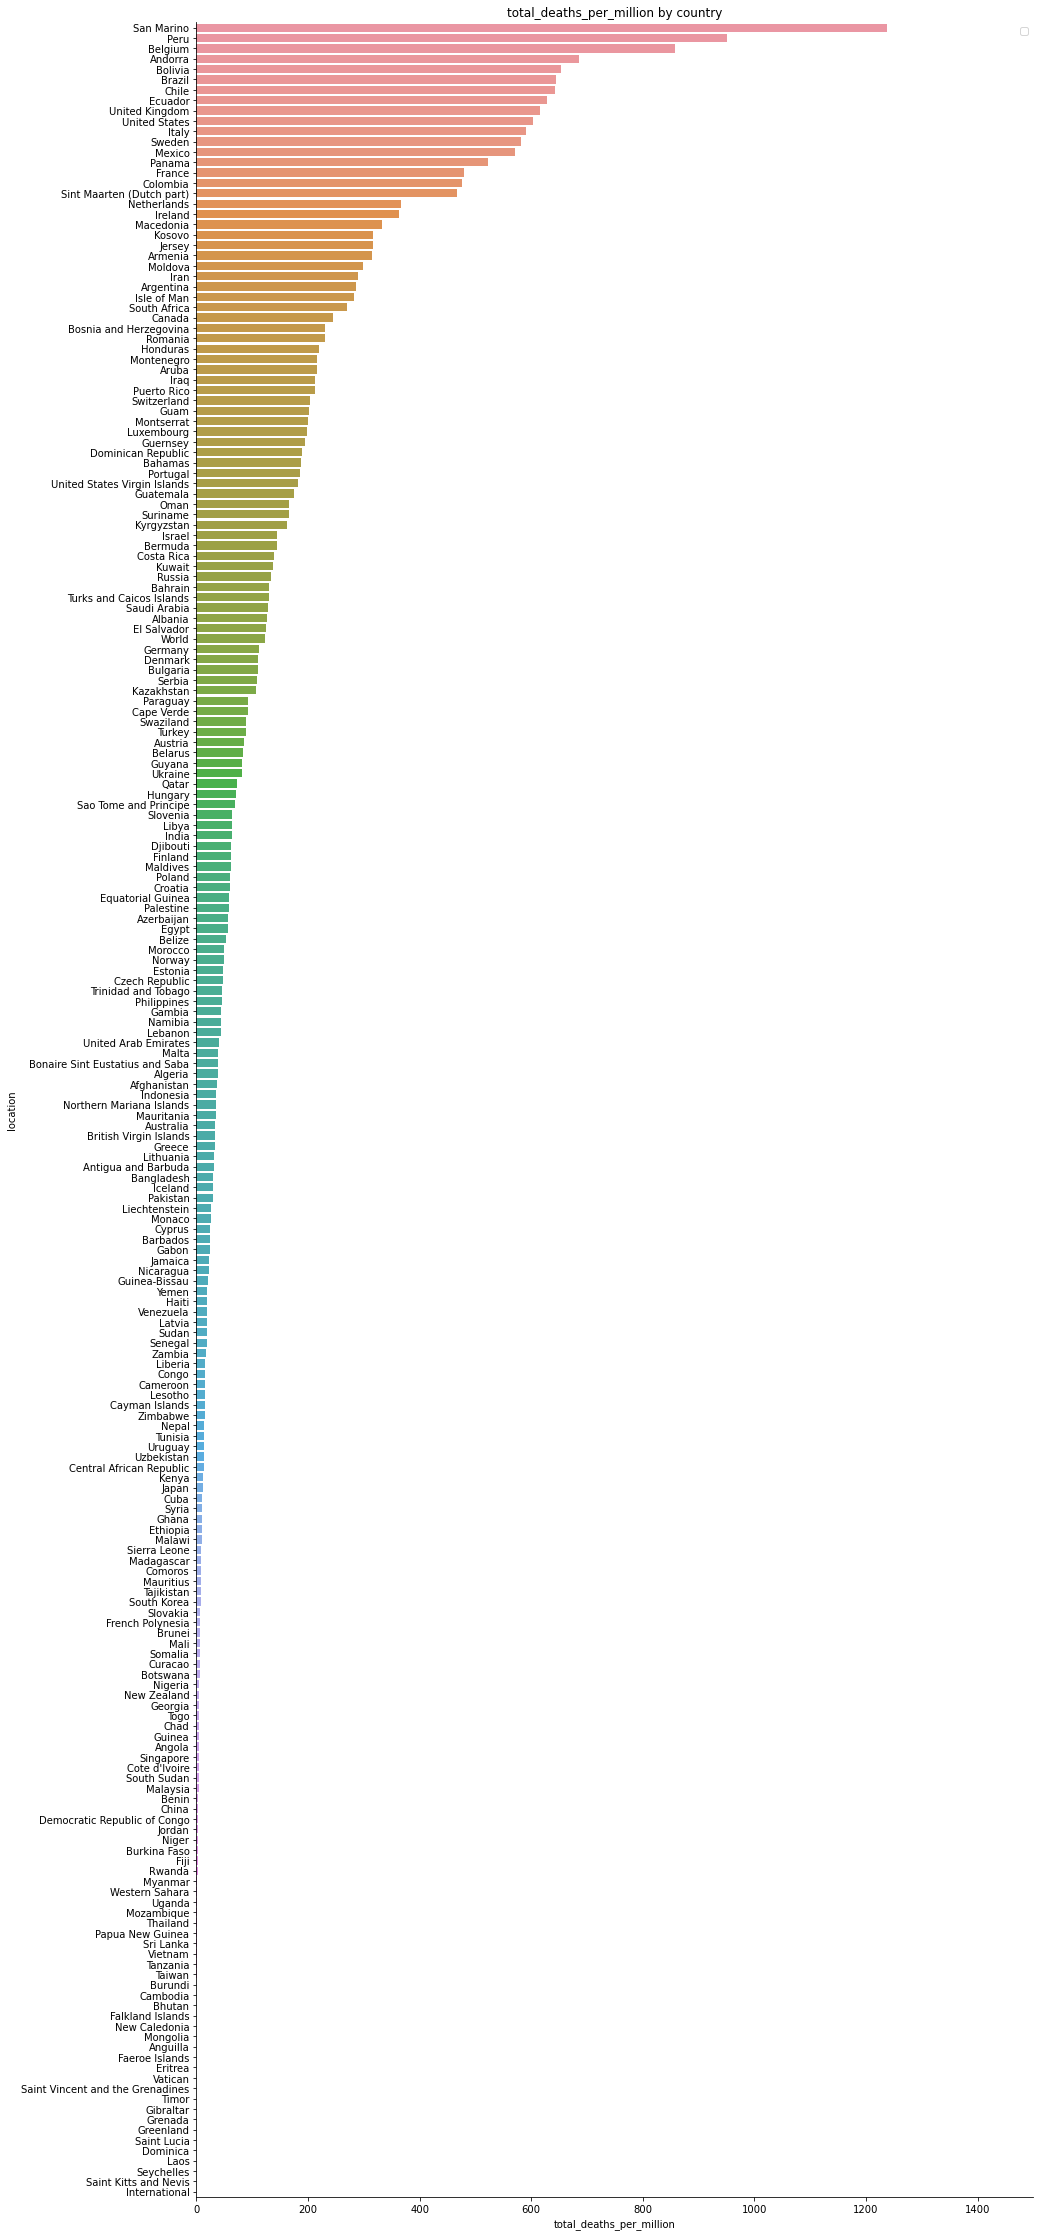

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

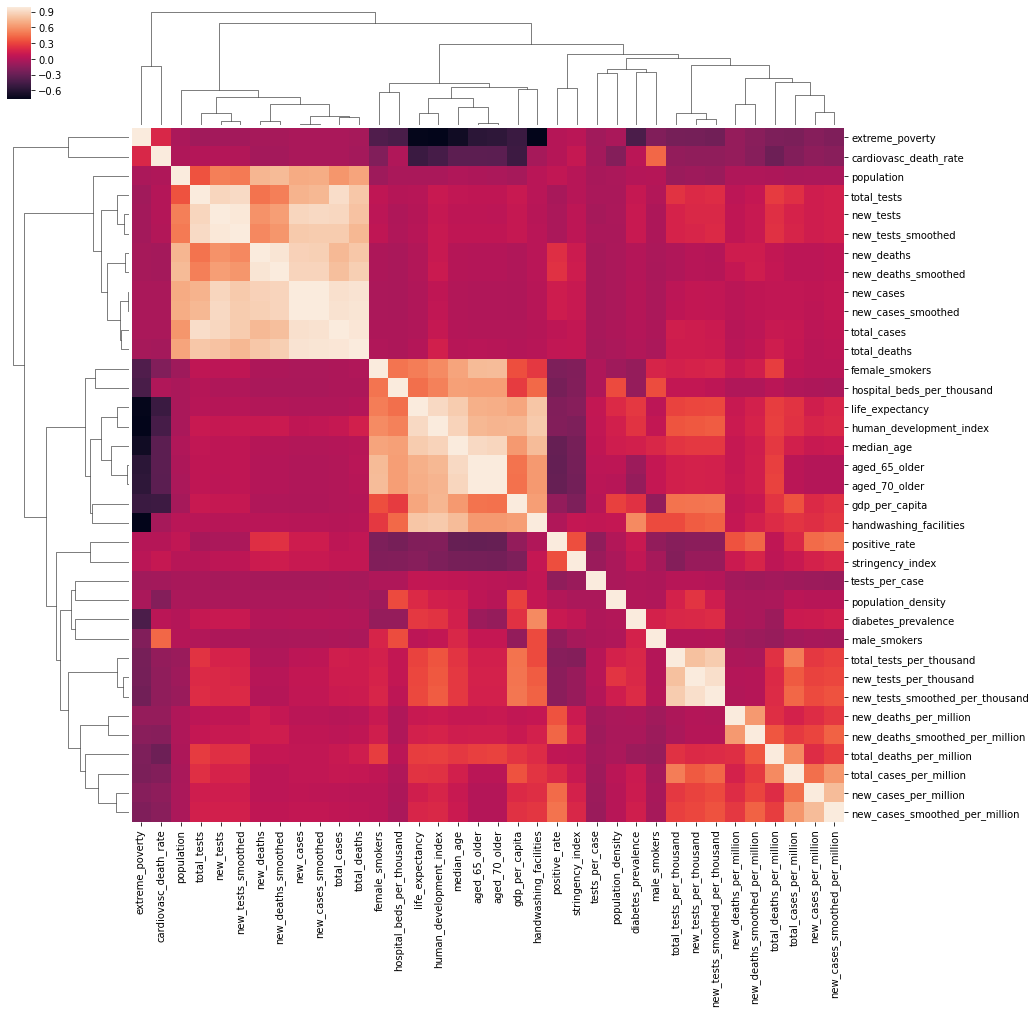

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9986169322267037 (+/- 0.0017899406539625057)
Coef :  [1.03192571e+00 8.28496313e-05 8.53527353e-05]
3 Last_days :  [[30543040 30837902 31091469]]
Today :  31091469
Prediction + :  534499
Tomorow :  31625968
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996249742118745 (+/- 0.00015196851878308257)
Coef :  [0.21228583 0.3874654  0.41033508]
3 Last_days :  [[952730 957798 961352]]
Today :  961352
Prediction + :  9768
Tomorow :  971120
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.003816493118957783 (+/- 1.4157696152083776)
Coef :  [-0.77742768  0.80103539  0.98137888]
3 Last_days :  [[428696 442194 453763]]
Today :  453763
Prediction + :  12380
Tomorow :  466143
                                     
--------- Total Death -----------------
                                     
R^2: 0.7438637170287875 (+/- 0.35240818183028466)
Coef :  [-0.74661976  0.78781473  0.95776021]
3 Last_days :  [[31249 31274 31285]]
Today :  31285
Prediction + :  39
Tomorow :  31324
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9645185548703864 (+/- 0.032753014300255893)
Coef :  [-0.32967259 -0.01081986  1.33475906]
3 Last_days :  [[90308 90333 90369]]
Today :  90369
Prediction + :  30
Tomorow :  90399
                                     
--------- Total Death -----------------
                                     
R^2: -46.47550619068492 (+/- 67.03955433333505)
Coef :  [-0.07758785  0.01247807  1.05682923]
3 Last_days :  [[4737 4737 4737]]
Today :  4737
Prediction + :  5
Tomorow :  4742
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9226189447209251 (+/- 0.10816789807330036)
Coef :  [-0.81220876  0.89260884  0.91904065]
3 Last_days :  [[294932 296569 298156]]
Today :  298156
Prediction + :  1436
Tomorow :  299592
                                     
--------- Total Death -----------------
                                     
R^2: -0.24658899791024094 (+/- 1.7408426364040692)
Coef :  [-0.82039554  0.89564604  0.9237582 ]
3 Last_days :  [[35668 35692 35707]]
Today :  35707
Prediction + :  39
Tomorow :  35746
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.659351746401943 (+/- 0.4747051528328538)
Coef :  [-0.31662309  0.17674039  1.1455432 ]
3 Last_days :  [[640040 640040 640040]]
Today :  640040
Prediction + :  3861
Tomorow :  643901
                                     
--------- Total Death -----------------
                                     
R^2: 0.3970583441424802 (+/- 0.5663143482541199)
Coef :  [-0.73055995  0.64210132  1.08744755]
3 Last_days :  [[30495 30495 30495]]
Today :  30495
Prediction + :  7
Tomorow :  30502
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9266930987272634 (+/- 0.10185703481203189)
Coef :  [0.12037823 0.44292839 0.44932124]
3 Last_days :  [[6724667 6764962 6804814]]
Today :  6804814
Prediction + :  76614
Tomorow :  6881428
                                     
--------- Total Death -----------------
                                     
R^2: 0.9803141163892621 (+/- 0.026535026005518096)
Coef :  [-0.40432518  0.67148872  0.7355838 ]
3 Last_days :  [[198589 199258 199509]]
Today :  199509
Prediction + :  1194
Tomorow :  200703
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9952198621826511 (+/- 0.005642926096928817)
Coef :  [-0.67567988  0.82524694  0.85137757]
3 Last_days :  [[385936 390358 394257]]
Today :  394257
Prediction + :  3347
Tomorow :  397604
                                     
--------- Total Death -----------------
                                     
R^2: 0.22612136910094952 (+/- 1.0538535745037514)
Coef :  [-0.76448456  0.83005745  0.93368286]
3 Last_days :  [[41732 41759 41777]]
Today :  41777
Prediction + :  53
Tomorow :  41830
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6939790324647707 (+/- 0.4318596063726219)
Coef :  [-0.77649302  0.84841541  0.92795563]
3 Last_days :  [[270070 271415 272337]]
Today :  272337
Prediction + :  1272
Tomorow :  273609
                                     
--------- Total Death -----------------
                                     
R^2: 0.2333029087216456 (+/- 1.075769891407974)
Coef :  [-0.78411725  0.83903166  0.94428316]
3 Last_days :  [[9384 9386 9386]]
Today :  9386
Prediction + :  7
Tomorow :  9393
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9988385821410999 (+/- 0.0011134186576903854)
Coef :  [0.33861891 0.33801583 0.33424015]
3 Last_days :  [[416198 419043 422140]]
Today :  422140
Prediction + :  3151
Tomorow :  425291
                                     
--------- Total Death -----------------
                                     
R^2: 0.9173098154209768 (+/- 0.11625331264296941)
Coef :  [0.13816978 0.44213438 0.43066107]
3 Last_days :  [[23952 24118 24301]]
Today :  24301
Prediction + :  206
Tomorow :  24507
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995803238856203 (+/- 0.0003450867902945388)
Coef :  [-0.63668954  0.80312742  0.83095214]
3 Last_days :  [[299810 301348 302867]]
Today :  302867
Prediction + :  1235
Tomorow :  304102
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993553137801804 (+/- 0.0004820204064409245)
Coef :  [-0.81505903  0.89472726  0.91850857]
3 Last_days :  [[7377 7445 7506]]
Today :  7506
Prediction + :  55
Tomorow :  7561
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9456150702574222 (+/- 0.07302919086565986)
Coef :  [-0.12204817  0.51080481  0.62371938]
3 Last_days :  [[4495183 4528240 4544629]]
Today :  4544629
Prediction + :  62807
Tomorow :  4607436
                                     
--------- Total Death -----------------
                                     
R^2: 0.4555848585917426 (+/- 0.762914138942155)
Coef :  [-0.03367678  0.48758896  0.55656497]
3 Last_days :  [[135793 136532 136895]]
Today :  136895
Prediction + :  1630
Tomorow :  138525
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(31091469, 961352, 31625968, 971120),
 (453763, 31285, 466143, 31324),
 (298156, 35707, 299592, 35746),
 (640040, 30495, 643901, 30502),
 (6804814, 199509, 6881428, 200703),
 (90369, 4737, 90399, 4742),
 (394257, 41777, 397604, 41830),
 (272337, 9386, 273609, 9393),
 (422140, 24301, 425291, 24507),
 (302867, 7506, 304102, 7561),
 (4544629, 136895, 4607436, 138525)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-21,France,466143.0,0.0,31324.0,0.0,0.0,0.0
0,2020-09-21,China,90399.0,0.0,4742.0,0.0,0.0,0.0
0,2020-09-21,Italy,299592.0,0.0,35746.0,0.0,0.0,0.0
0,2020-09-21,Spain,643901.0,0.0,30502.0,0.0,0.0,0.0
0,2020-09-21,United States,6881428.0,0.0,200703.0,0.0,0.0,0.0
0,2020-09-21,World,31625968.0,0.0,971120.0,0.0,0.0,0.0
0,2020-09-21,United Kingdom,397604.0,0.0,41830.0,0.0,0.0,0.0
0,2020-09-21,Germany,273609.0,0.0,9393.0,0.0,0.0,0.0
0,2020-09-21,Iran,425291.0,0.0,24507.0,0.0,0.0,0.0
0,2020-09-21,Turkey,304102.0,0.0,7561.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")